In [1]:
#import necessary modules
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#import necessary modules that are included into the function
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, RepeatedKFold, LeaveOneOut, LeavePOut,ShuffleSplit
import itertools 
import matplotlib.pyplot as plt
from functools import reduce

# files
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


c:\Users\foeke\OneDrive\Documenten\submitting paper\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## import and examine data (local)

In [2]:
dataset = pd.read_csv(r"C:/Users/foeke/OneDrive/Documenten/submitting paper/All scripts - paper/data/LocalModelData/ModellingDataset-Local.csv", sep=';')
pd.set_option('display.max_columns', None)
dataset.describe()

,Lopend_gemiddelde,Latitude,Longitude,elevation,industry_100,industry_1000,industry_25,industry_300,industry_3000,industry_50,industry_500,industry_5000,nightlight_3150,nightlight_450,nightlight_4950,nightlight_900,OMI_mean_filt,population_1000,population_3000,population_5000,radiation,road_class_1_100,road_class_1_1000,road_class_1_25,road_class_1_300,road_class_1_3000,road_class_1_50,road_class_1_500,road_class_1_5000,road_class_2_100,road_class_2_1000,road_class_2_25,road_class_2_300,road_class_2_3000,road_class_2_50,road_class_2_500,road_class_2_5000,road_class_3_100,road_class_3_1000,road_class_3_25,road_class_3_300,road_class_3_3000,road_class_3_50,road_class_3_500,road_class_3_5000,Rsp,temperature_2m_1,temperature_2m_10,temperature_2m_11,temperature_2m_12,temperature_2m_2,temperature_2m_3,temperature_2m_4,temperature_2m_5,temperature_2m_6,temperature_2m_7,temperature_2m_8,temperature_2m_9,trop_mean_filt,wind_speed_10m_1,wind_speed_10m_10,wind_speed_10m_11,wind_speed_10m_12,wind_speed_10m_2,wind_speed_10m_3,wind_speed_10m_4,wind_speed_10m_5,wind_speed_10m_6,wind_speed_10m_7,wind_speed_10m_8,wind_speed_10m_9,jan,feb,mar,apr,may,jun,jul,aug,oct,sep,nov,dec,BldDen100,BldDen500,BldDen1000,NDVI,trafBuf25,trafBuf50,trafBuf100,trafBuf400,trafBuf800
count,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,1.320000e+02,132.000000,132.000000,1.320000e+02,132.000000,132.000000,132.000000,132.000000,1.320000e+02,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,132.000000,128.000000,31.000000,36.000000,47.000000,91.000000,121.000000
mean,35.226515,52.372723,4.887527,4.998295,402.543769,127810.374222,40.857247,5500.518358,2.082524e+06,100.197360,22542.127182,7.370602e+06,35.905065,42.025057,30.147216,41.298078,6.650835e+15,13436.109004,111157.013204,275107.860752,2.856060,32.446984,2154.787414,2.545587,270.440902,24826.558957,7.410652,649.679403,88821.129723,82.151582,4018.625685,11.268752,421.383174,26465.915084,27.745197,1081.499602,58553.226771,374.288432,25838.098341,39.839338,2713.633709,215141.744244,103.100403,7127.293323,507543.054814,9.361693,1.975841,13.775503,8.027410,5.200049,4.873354,8.080632,8.573431,14.355789,17.701253,17.905929,17.618928,14.355763,0.000091,3.939325,5.674535,4.426238,5.157636,5.051674,4.443038,4.029110,3.708070,4.335704,3.728119,3.496959,3.879354,60.791389,80.768208,54.028410,30.037180,34.589959,70.454947,129.275163,89.237420,80.746612,175.237674,105.636421,135.165371,0.842823,0.764579,0.722572,1788.968750,1021.271898,1080.411724,1197.058292,1153.746274,1206.573949
std,8.899995,0.032779,0.037693,2.244744,2532.895424,189702.391359,329.793101,17570.964611,1.926233e+06,780.612149,49343.146134,4.493604e+06,9.347635,17.262283,6.854039,15.636107,1.640597e+14,3020.579532,26750.374127,64093.403062,0.015723,129.681015,3131.494715,13.890270,658.889360,12220.175508,36.552953,1273.681361,16801.112766,138.279523,2568.553719,23.780049,525.167796,6971.116805,52.754438,1110.967673,9542.071192,246.423919,9567.874432,38.155453,1325.048619,55253.597896,85.684133,3102.116499,109906.623391,0.564695,0.140377,0.051606,0.137695,0.116100,0.014854,0.021869,0.014262,0.088980,0.095052,0.032220,0.011000,0.068629,0.000003,0.199956,0.284431,0.261652,0.254648,0.220771,0.157918,0.172030,0.136298,0.161069,0.153534,

## data processing

In [3]:
#get rid off unnecessary variables

#unique identifier and geodata
dataset = dataset.drop(['Longitude', 'Latitude'], axis=1)
print(len(dataset.columns))

90


In [4]:
#number of NA values in every column
dataset.isnull().sum(axis = 0)

Lopend_gemiddelde      0
elevation              0
industry_100           0
industry_1000          0
industry_25            0
                    ... 
trafBuf25            101
trafBuf50             96
trafBuf100            85
trafBuf400            41
trafBuf800            11
Length: 90, dtype: int64

In [5]:
#replace NA with 0
dataset=dataset.fillna(0)

## Define response- and predictor variables

In [6]:
##CREATE DEPENDENT- AND INDEPENDENT VARIABLES
#store all column names
all_column_names = dataset.columns

#create dataset with only predictor variables
x = dataset.drop(["Lopend_gemiddelde"], axis=1)
#store column names of predictor variables
feature_names = x.columns
#dependent variable
y = dataset["Lopend_gemiddelde"]
#verify if dependent variable is out of dataset
print(len(feature_names))
#transform dependent- and independent variables to numpy arrays for calculations
x = np.array(x)
y = np.array(y)

89


## Feature Selection (via median)

In [7]:
#CONSTRUCT FUNCTION - CV FEATURE IMPORTANCE (MEDIAN)

#set initial model
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)

#generate function that creates K-fold CV, thereby creating shap summary plot for each loop/fold.
def cvfi(data_x, data_y, model, nofolds, names):
    ss = ShuffleSplit(n_splits=nofolds, test_size=0.25, random_state=0)
    
    total = list(itertools.repeat(0, 89)) #85 copies of 0 - needed for generating mean of CV
    ranking = []
    
    for train, test in ss.split(data_x, data_y):
        data_x_train = np.array(data_x[train])
        data_y_train = np.array(data_y[train])
        data_x_test = np.array(data_x[test])

        # Train the model on training data
        model.fit(data_x_train, data_y_train)
        
        shap_values = shap.TreeExplainer(model).shap_values(data_x_train)
        shap.summary_plot(shap_values, data_x_train, feature_names=names, plot_type='bar')
        
        #https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d
        # according to this source, training dataset is used to calculate shap values
        
        df = pd.DataFrame(feature_names, np.abs(shap_values).mean(0))
        df['index'] = df.index
        df.reset_index(drop=True, inplace=True)
        df.columns = [''] * len(df.columns)
        
        df.columns = ['name','shap']
        print(df)
        df_sort = df.sort_values(by = ['shap'], ascending=False)
        df_sort['rank'] = np.arange(1, len(df) * 1 + 1, 1)
        df_new = df_sort.drop(['shap'], axis=1)
        print(df_new)
        rank_array = df_new.values
        
        print(rank_array)
        ranking.append(rank_array)

        #convert importance values to numpy array
        vals= np.abs(shap_values).mean(0)
        print(vals)
        
       
        
        print(len(vals))
        total += vals
    
    print(total)
    print(ranking)
    cvfi.ranking = ranking
    cvfi.meanfi = total/nofolds #allows use of local variable outside function
    

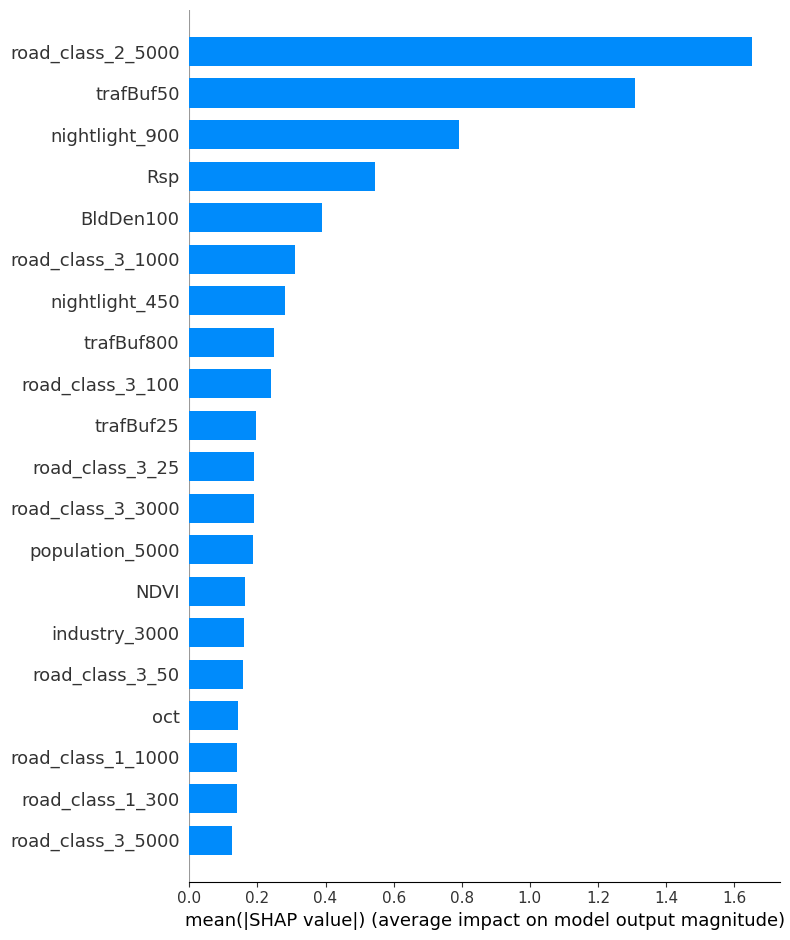

             name      shap
0       elevation  0.109797
1    industry_100  0.001587
2   industry_1000  0.023119
3     industry_25  0.001110
4    industry_300  0.016126
..            ...       ...
84      trafBuf25  0.196268
85      trafBuf50  1.308875
86     trafBuf100  0.022738
87     trafBuf400  0.066743
88     trafBuf800  0.248845

[89 rows x 2 columns]
                 name  rank
33  road_class_2_5000     1
85          trafBuf50     2
12     nightlight_900     3
42                Rsp     4
80          BldDen100     5
..                ...   ...
56   wind_speed_10m_1    85
23    road_class_1_50    86
1        industry_100    87
3         industry_25    88
6         industry_50    89

[89 rows x 2 columns]
[['road_class_2_5000' 1]
 ['trafBuf50' 2]
 ['nightlight_900' 3]
 ['Rsp' 4]
 ['BldDen100' 5]
 ['road_class_3_1000' 6]
 ['nightlight_450' 7]
 ['trafBuf800' 8]
 ['road_class_3_100' 9]
 ['trafBuf25' 10]
 ['road_class_3_25' 11]
 ['road_class_3_3000' 12]
 ['population_5000' 13]
 ['NDVI' 

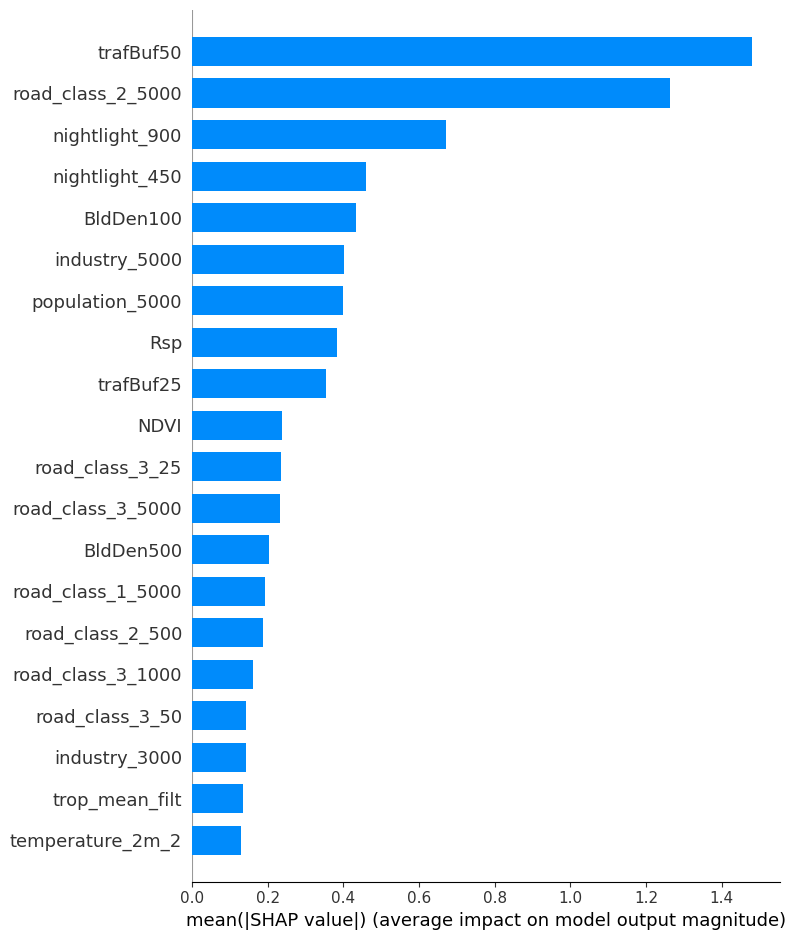

             name      shap
0       elevation  0.077517
1    industry_100  0.005489
2   industry_1000  0.034523
3     industry_25  0.001728
4    industry_300  0.022199
..            ...       ...
84      trafBuf25  0.353858
85      trafBuf50  1.480260
86     trafBuf100  0.040625
87     trafBuf400  0.065941
88     trafBuf800  0.089430

[89 rows x 2 columns]
                 name  rank
85          trafBuf50     1
33  road_class_2_5000     2
12     nightlight_900     3
10     nightlight_450     4
80          BldDen100     5
..                ...   ...
64   wind_speed_10m_6    85
72                may    86
45  temperature_2m_11    87
1        industry_100    88
3         industry_25    89

[89 rows x 2 columns]
[['trafBuf50' 1]
 ['road_class_2_5000' 2]
 ['nightlight_900' 3]
 ['nightlight_450' 4]
 ['BldDen100' 5]
 ['industry_5000' 6]
 ['population_5000' 7]
 ['Rsp' 8]
 ['trafBuf25' 9]
 ['NDVI' 10]
 ['road_class_3_25' 11]
 ['road_class_3_5000' 12]
 ['BldDen500' 13]
 ['road_class_1_5000' 14]


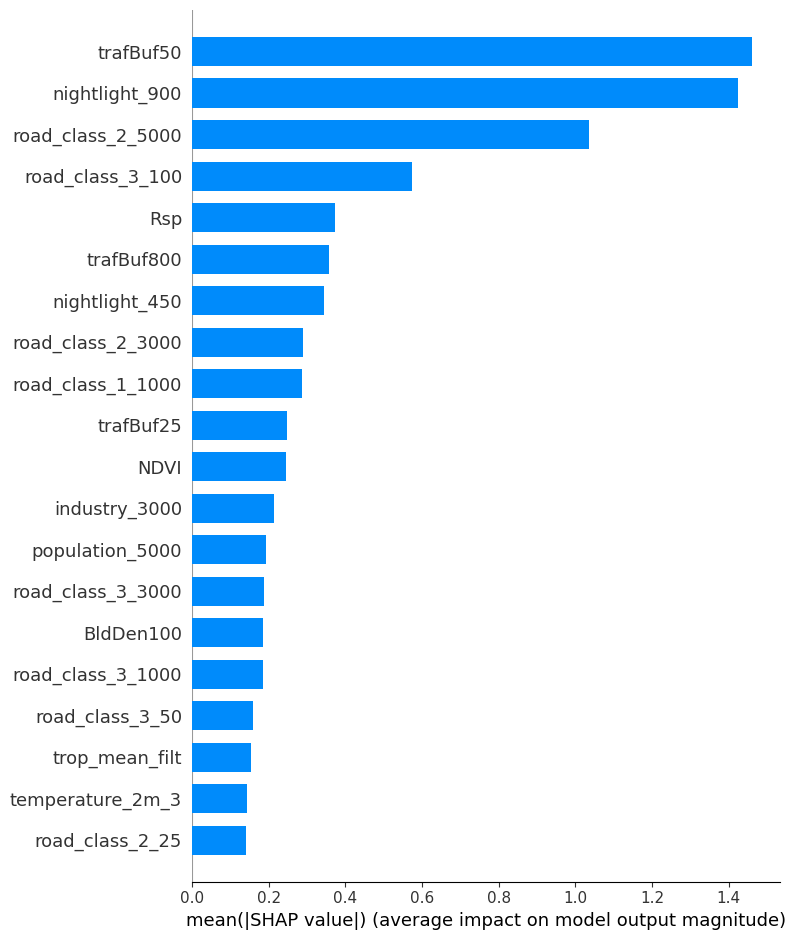

             name      shap
0       elevation  0.110162
1    industry_100  0.002720
2   industry_1000  0.056384
3     industry_25  0.000334
4    industry_300  0.010619
..            ...       ...
84      trafBuf25  0.246970
85      trafBuf50  1.460742
86     trafBuf100  0.036049
87     trafBuf400  0.044479
88     trafBuf800  0.357960

[89 rows x 2 columns]
                 name  rank
85          trafBuf50     1
12     nightlight_900     2
33  road_class_2_5000     3
34   road_class_3_100     4
42                Rsp     5
..                ...   ...
70                mar    85
20    road_class_1_25    86
1        industry_100    87
6         industry_50    88
3         industry_25    89

[89 rows x 2 columns]
[['trafBuf50' 1]
 ['nightlight_900' 2]
 ['road_class_2_5000' 3]
 ['road_class_3_100' 4]
 ['Rsp' 5]
 ['trafBuf800' 6]
 ['nightlight_450' 7]
 ['road_class_2_3000' 8]
 ['road_class_1_1000' 9]
 ['trafBuf25' 10]
 ['NDVI' 11]
 ['industry_3000' 12]
 ['population_5000' 13]
 ['road_class_3_

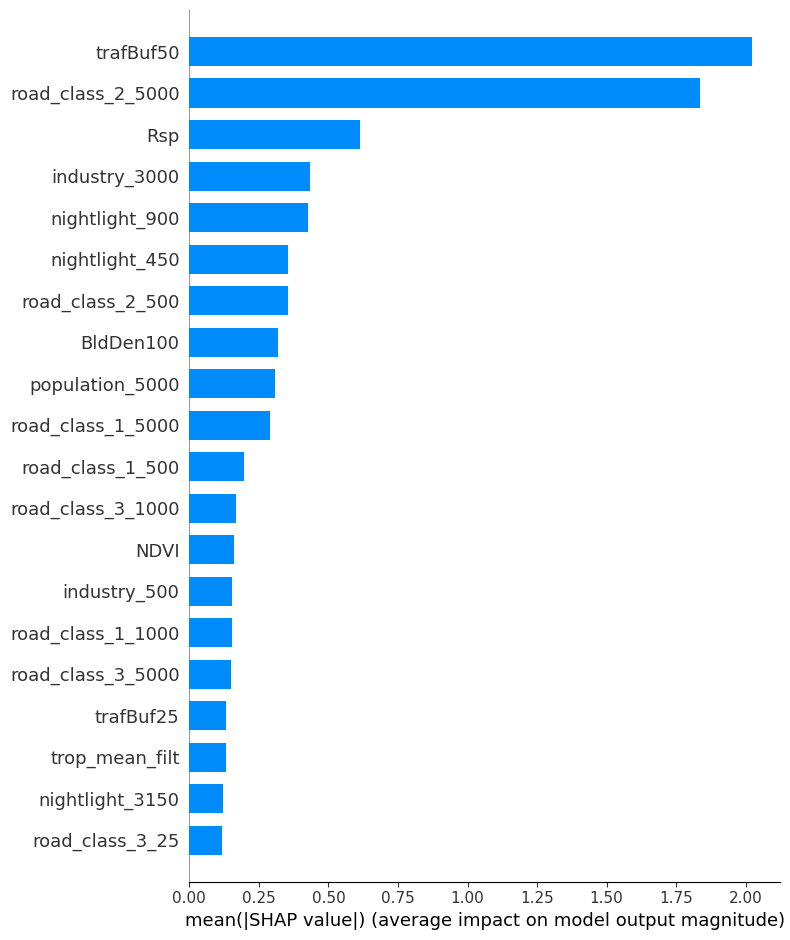

             name      shap
0       elevation  0.086447
1    industry_100  0.000556
2   industry_1000  0.073927
3     industry_25  0.001722
4    industry_300  0.018221
..            ...       ...
84      trafBuf25  0.132506
85      trafBuf50  2.022075
86     trafBuf100  0.061373
87     trafBuf400  0.066800
88     trafBuf800  0.083593

[89 rows x 2 columns]
                 name  rank
85          trafBuf50     1
33  road_class_2_5000     2
42                Rsp     3
5       industry_3000     4
12     nightlight_900     5
..                ...   ...
72                may    85
6         industry_50    86
20    road_class_1_25    87
3         industry_25    88
1        industry_100    89

[89 rows x 2 columns]
[['trafBuf50' 1]
 ['road_class_2_5000' 2]
 ['Rsp' 3]
 ['industry_3000' 4]
 ['nightlight_900' 5]
 ['nightlight_450' 6]
 ['road_class_2_500' 7]
 ['BldDen100' 8]
 ['population_5000' 9]
 ['road_class_1_5000' 10]
 ['road_class_1_500' 11]
 ['road_class_3_1000' 12]
 ['NDVI' 13]
 ['industr

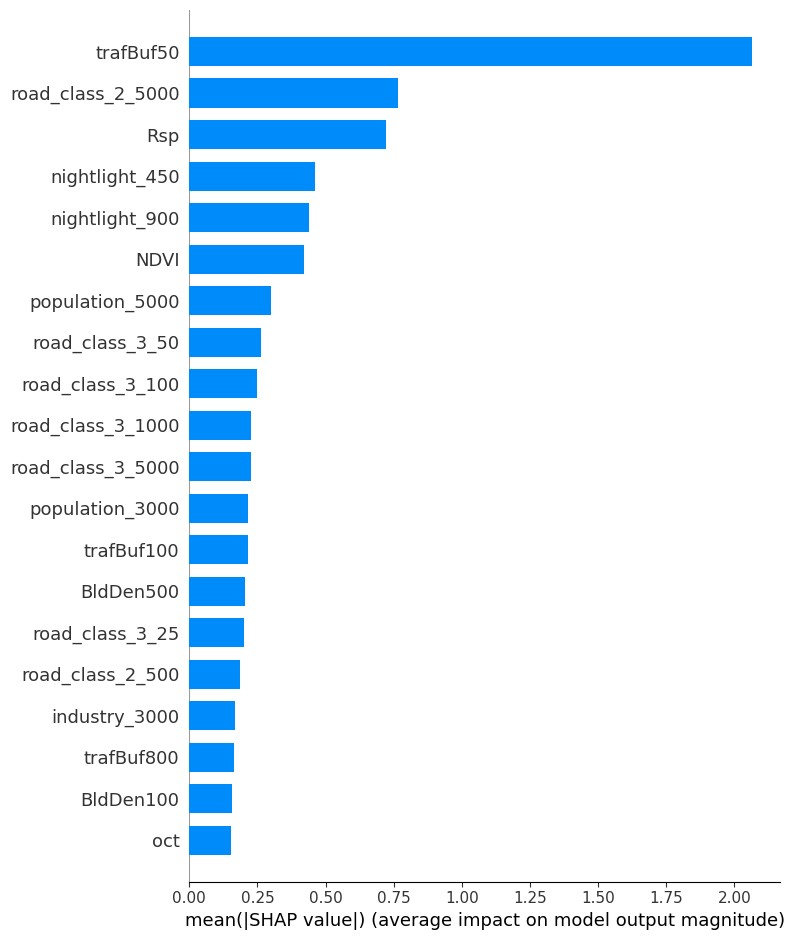

             name      shap
0       elevation  0.080464
1    industry_100  0.004051
2   industry_1000  0.109279
3     industry_25  0.000023
4    industry_300  0.004715
..            ...       ...
84      trafBuf25  0.128865
85      trafBuf50  2.064434
86     trafBuf100  0.214212
87     trafBuf400  0.088899
88     trafBuf800  0.162907

[89 rows x 2 columns]
                 name  rank
85          trafBuf50     1
33  road_class_2_5000     2
42                Rsp     3
10     nightlight_450     4
12     nightlight_900     5
..                ...   ...
1        industry_100    85
20    road_class_1_25    86
6         industry_50    87
23    road_class_1_50    88
3         industry_25    89

[89 rows x 2 columns]
[['trafBuf50' 1]
 ['road_class_2_5000' 2]
 ['Rsp' 3]
 ['nightlight_450' 4]
 ['nightlight_900' 5]
 ['NDVI' 6]
 ['population_5000' 7]
 ['road_class_3_50' 8]
 ['road_class_3_100' 9]
 ['road_class_3_1000' 10]
 ['road_class_3_5000' 11]
 ['population_3000' 12]
 ['trafBuf100' 13]
 ['BldDe

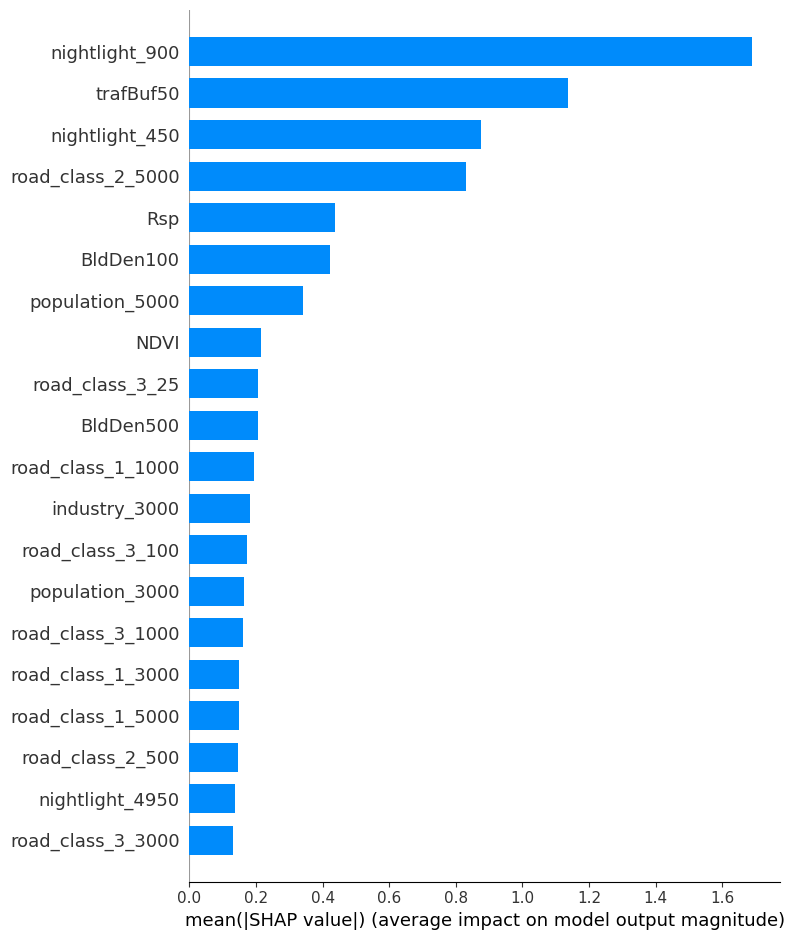

             name      shap
0       elevation  0.067425
1    industry_100  0.001243
2   industry_1000  0.056975
3     industry_25  0.000149
4    industry_300  0.015061
..            ...       ...
84      trafBuf25  0.044185
85      trafBuf50  1.135559
86     trafBuf100  0.056373
87     trafBuf400  0.101973
88     trafBuf800  0.103998

[89 rows x 2 columns]
                 name  rank
12     nightlight_900     1
85          trafBuf50     2
10     nightlight_450     3
33  road_class_2_5000     4
42                Rsp     5
..                ...   ...
23    road_class_1_50    85
75                aug    86
1        industry_100    87
6         industry_50    88
3         industry_25    89

[89 rows x 2 columns]
[['nightlight_900' 1]
 ['trafBuf50' 2]
 ['nightlight_450' 3]
 ['road_class_2_5000' 4]
 ['Rsp' 5]
 ['BldDen100' 6]
 ['population_5000' 7]
 ['NDVI' 8]
 ['road_class_3_25' 9]
 ['BldDen500' 10]
 ['road_class_1_1000' 11]
 ['industry_3000' 12]
 ['road_class_3_100' 13]
 ['population_3000'

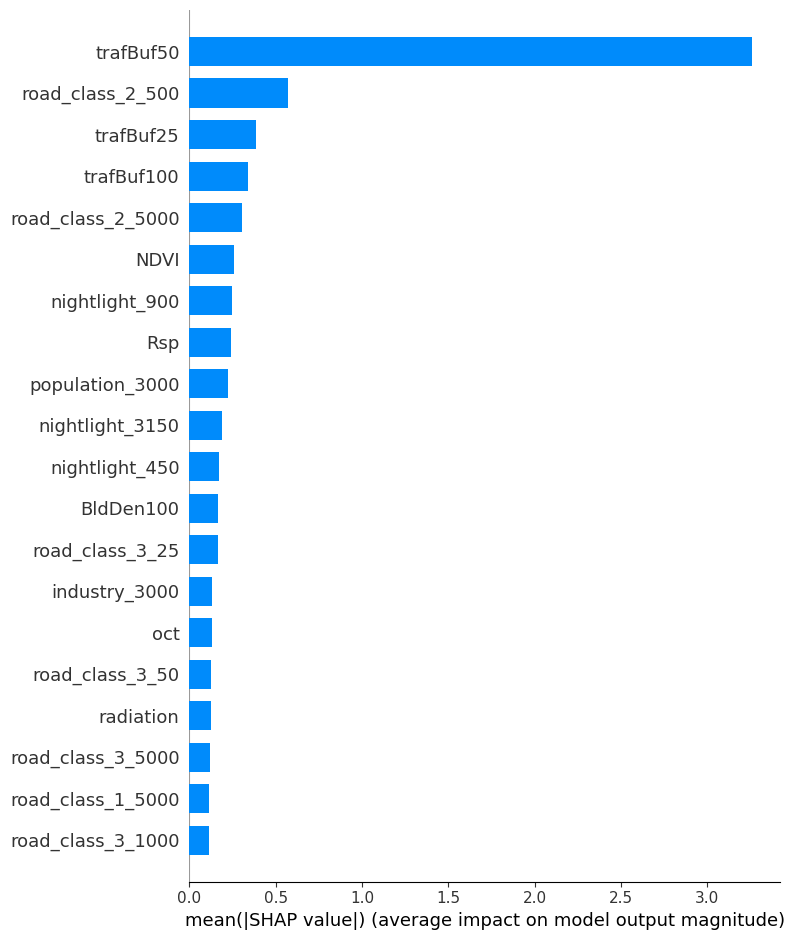

             name      shap
0       elevation  0.079764
1    industry_100  0.002914
2   industry_1000  0.042906
3     industry_25  0.002353
4    industry_300  0.014944
..            ...       ...
84      trafBuf25  0.387135
85      trafBuf50  3.259272
86     trafBuf100  0.340471
87     trafBuf400  0.077613
88     trafBuf800  0.067016

[89 rows x 2 columns]
                 name  rank
85          trafBuf50     1
32   road_class_2_500     2
84          trafBuf25     3
86         trafBuf100     4
33  road_class_2_5000     5
..                ...   ...
64   wind_speed_10m_6    85
1        industry_100    86
20    road_class_1_25    87
3         industry_25    88
6         industry_50    89

[89 rows x 2 columns]
[['trafBuf50' 1]
 ['road_class_2_500' 2]
 ['trafBuf25' 3]
 ['trafBuf100' 4]
 ['road_class_2_5000' 5]
 ['NDVI' 6]
 ['nightlight_900' 7]
 ['Rsp' 8]
 ['population_3000' 9]
 ['nightlight_3150' 10]
 ['nightlight_450' 11]
 ['BldDen100' 12]
 ['road_class_3_25' 13]
 ['industry_3000' 14]
 [

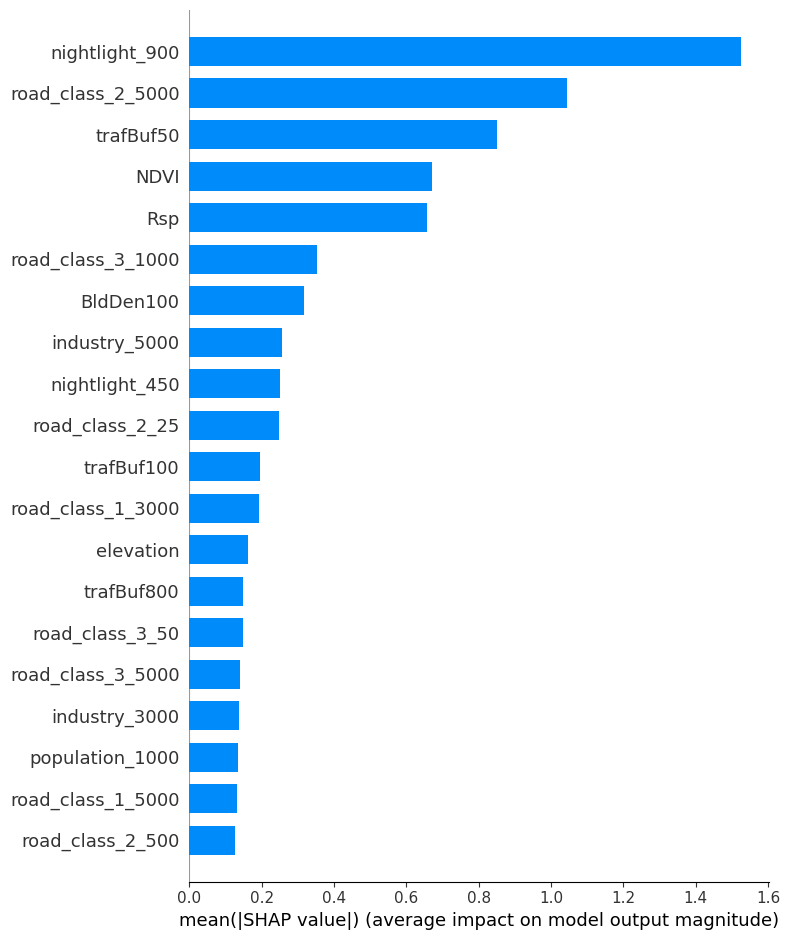

             name      shap
0       elevation  0.162364
1    industry_100  0.004207
2   industry_1000  0.052819
3     industry_25  0.000478
4    industry_300  0.018711
..            ...       ...
84      trafBuf25  0.086152
85      trafBuf50  0.849943
86     trafBuf100  0.196413
87     trafBuf400  0.032022
88     trafBuf800  0.149146

[89 rows x 2 columns]
                 name  rank
12     nightlight_900     1
33  road_class_2_5000     2
85          trafBuf50     3
83               NDVI     4
42                Rsp     5
..                ...   ...
46  temperature_2m_12    85
1        industry_100    86
20    road_class_1_25    87
3         industry_25    88
6         industry_50    89

[89 rows x 2 columns]
[['nightlight_900' 1]
 ['road_class_2_5000' 2]
 ['trafBuf50' 3]
 ['NDVI' 4]
 ['Rsp' 5]
 ['road_class_3_1000' 6]
 ['BldDen100' 7]
 ['industry_5000' 8]
 ['nightlight_450' 9]
 ['road_class_2_25' 10]
 ['trafBuf100' 11]
 ['road_class_1_3000' 12]
 ['elevation' 13]
 ['trafBuf800' 14]
 ['r

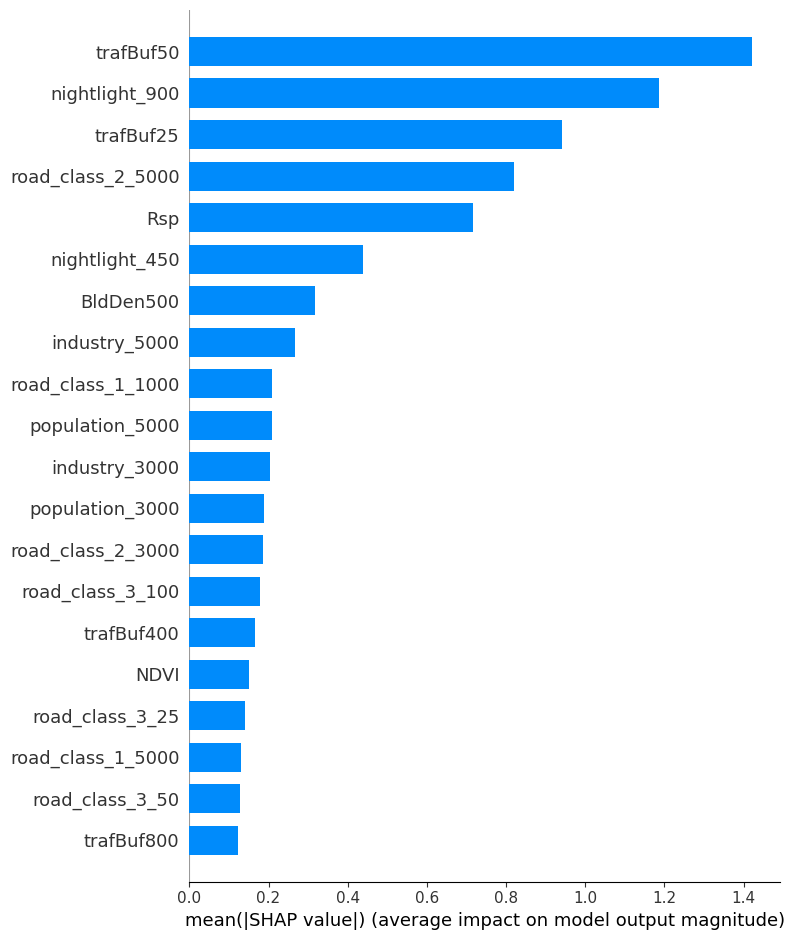

             name      shap
0       elevation  0.109135
1    industry_100  0.002168
2   industry_1000  0.037065
3     industry_25  0.001148
4    industry_300  0.012912
..            ...       ...
84      trafBuf25  0.942551
85      trafBuf50  1.420985
86     trafBuf100  0.058768
87     trafBuf400  0.165444
88     trafBuf800  0.123747

[89 rows x 2 columns]
                 name  rank
85          trafBuf50     1
12     nightlight_900     2
84          trafBuf25     3
33  road_class_2_5000     4
42                Rsp     5
..                ...   ...
54   temperature_2m_9    85
20    road_class_1_25    86
1        industry_100    87
6         industry_50    88
3         industry_25    89

[89 rows x 2 columns]
[['trafBuf50' 1]
 ['nightlight_900' 2]
 ['trafBuf25' 3]
 ['road_class_2_5000' 4]
 ['Rsp' 5]
 ['nightlight_450' 6]
 ['BldDen500' 7]
 ['industry_5000' 8]
 ['road_class_1_1000' 9]
 ['population_5000' 10]
 ['industry_3000' 11]
 ['population_3000' 12]
 ['road_class_2_3000' 13]
 ['road_c

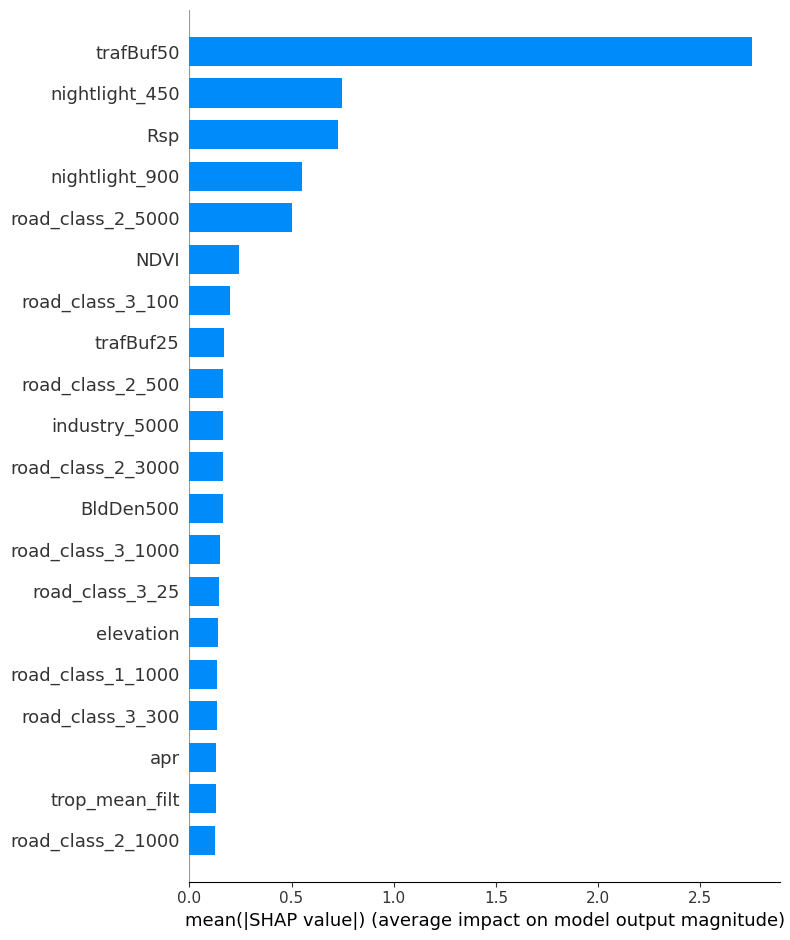

             name      shap
0       elevation  0.138080
1    industry_100  0.002122
2   industry_1000  0.032609
3     industry_25  0.002191
4    industry_300  0.019500
..            ...       ...
84      trafBuf25  0.171023
85      trafBuf50  2.752476
86     trafBuf100  0.014237
87     trafBuf400  0.077666
88     trafBuf800  0.056529

[89 rows x 2 columns]
                 name  rank
85          trafBuf50     1
10     nightlight_450     2
42                Rsp     3
12     nightlight_900     4
33  road_class_2_5000     5
..                ...   ...
57  wind_speed_10m_10    85
64   wind_speed_10m_6    86
6         industry_50    87
3         industry_25    88
1        industry_100    89

[89 rows x 2 columns]
[['trafBuf50' 1]
 ['nightlight_450' 2]
 ['Rsp' 3]
 ['nightlight_900' 4]
 ['road_class_2_5000' 5]
 ['NDVI' 6]
 ['road_class_3_100' 7]
 ['trafBuf25' 8]
 ['road_class_2_500' 9]
 ['industry_5000' 10]
 ['road_class_2_3000' 11]
 ['BldDen500' 12]
 ['road_class_3_1000' 13]
 ['road_class_3_

In [8]:
cvfi(x, y, rf, 10, feature_names) #argumens: dependent variable; independent variables; model; amount of k-fold; feature names

In [9]:
rank = cvfi.ranking
print(rank)

[array([['road_class_2_5000', 1],
       ['trafBuf50', 2],
       ['nightlight_900', 3],
       ['Rsp', 4],
       ['BldDen100', 5],
       ['road_class_3_1000', 6],
       ['nightlight_450', 7],
       ['trafBuf800', 8],
       ['road_class_3_100', 9],
       ['trafBuf25', 10],
       ['road_class_3_25', 11],
       ['road_class_3_3000', 12],
       ['population_5000', 13],
       ['NDVI', 14],
       ['industry_3000', 15],
       ['road_class_3_50', 16],
       ['oct', 17],
       ['road_class_1_1000', 18],
       ['road_class_1_300', 19],
       ['road_class_3_5000', 20],
       ['road_class_2_3000', 21],
       ['nightlight_4950', 22],
       ['elevation', 23],
       ['nightlight_3150', 24],
       ['road_class_1_5000', 25],
       ['population_3000', 26],
       ['road_class_3_300', 27],
       ['road_class_2_25', 28],
       ['temperature_2m_3', 29],
       ['road_class_2_1000', 30],
       ['road_class_1_500', 31],
       ['road_class_2_500', 32],
       ['industry_5000', 33],


In [10]:
first_round = rank[0]
second_round = rank[1]
third_round = rank[2]
fourth_round = rank[3]
fifth_round = rank[4]
sixth_round = rank[5]
seventh_round = rank[6]
eigth_round = rank[7]
ninth_round = rank[8]
tenth_round = rank[9]


In [11]:
#create pandas dataframe from each fold of ranking
df_1 = pd.DataFrame(first_round, columns = ['name', 'rank'])
df_2 = pd.DataFrame(second_round, columns = ['name', 'rank_2'])
df_3 = pd.DataFrame(third_round, columns = ['name', 'rank_3'])
df_4 = pd.DataFrame(fourth_round, columns = ['name', 'rank_4'])
df_5 = pd.DataFrame(fifth_round, columns = ['name', 'rank_5'])
df_6 = pd.DataFrame(sixth_round, columns = ['name', 'rank_6'])
df_7 = pd.DataFrame(seventh_round, columns = ['name', 'rank_7'])
df_8 = pd.DataFrame(eigth_round, columns = ['name', 'rank_8'])
df_9 = pd.DataFrame(ninth_round, columns = ['name', 'rank_9'])
df_10 = pd.DataFrame(tenth_round, columns = ['name', 'rank_10'])
result = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8, df_9, df_10], axis=1)
print(result)

                 name rank               name rank_2               name   
0   road_class_2_5000    1          trafBuf50      1          trafBuf50  \
1           trafBuf50    2  road_class_2_5000      2     nightlight_900   
2      nightlight_900    3     nightlight_900      3  road_class_2_5000   
3                 Rsp    4     nightlight_450      4   road_class_3_100   
4           BldDen100    5          BldDen100      5                Rsp   
..                ...  ...                ...    ...                ...   
84   wind_speed_10m_1   85   wind_speed_10m_6     85                mar   
85    road_class_1_50   86                may     86    road_class_1_25   
86       industry_100   87  temperature_2m_11     87       industry_100   
87        industry_25   88       industry_100     88        industry_50   
88        industry_50   89        industry_25     89        industry_25   

   rank_3               name rank_4               name rank_5   
0       1          trafBuf50      

In [12]:
#store all dataframes into one
dfs = [df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8, df_9, df_10]

In [13]:
#assign all dataframes to one dataframe that shows ranking per fold.
df_allranks = reduce(lambda left,right: pd.merge(left,right,on='name'), dfs)
print(df_allranks)

                 name rank rank_2 rank_3 rank_4 rank_5 rank_6 rank_7 rank_8   
0   road_class_2_5000    1      2      3      2      2      4      5      2  \
1           trafBuf50    2      1      1      1      1      2      1      3   
2      nightlight_900    3      3      2      5      5      1      7      1   
3                 Rsp    4      8      5      3      3      5      8      5   
4           BldDen100    5      5     15      8     19      6     12      7   
..                ...  ...    ...    ...    ...    ...    ...    ...    ...   
84   wind_speed_10m_1   85     75     72     76     59     70     74     84   
85    road_class_1_50   86     76     79     52     88     85     67     52   
86       industry_100   87     88     87     89     85     87     86     86   
87        industry_25   88     89     89     88     89     89     88     88   
88        industry_50   89     81     88     86     87     88     89     89   

   rank_9 rank_10  
0       4       5  
1       1  

In [14]:
#drop string variable to do numpy calculations - necessary for obtaining median
df_fornumpy = df_allranks.drop(['name'], axis=1)
df_fornumpy.head()

,rank,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9,rank_10
0,1,2,3,2,2,4,5,2,4,5
1,2,1,1,1,1,2,1,3,1,1
2,3,3,2,5,5,1,7,1,2,4
3,4,8,5,3,3,5,8,5,5,3
4,5,5,15,8,19,6,12,7,27,24


In [15]:
#convert dataframe to numpy array. Moreover sort values per list to obtain median.
df_num = df_fornumpy
num = df_num.to_numpy()
num_sort = np.sort(num)
print(num_sort)

[[1 2 2 2 2 3 4 4 5 5]
 [1 1 1 1 1 1 1 2 2 3]
 [1 1 2 2 3 3 4 5 5 7]
 [3 3 3 4 5 5 5 5 8 8]
 [5 5 6 7 8 12 15 19 24 27]
 [6 6 10 12 13 15 16 16 20 23]
 [2 3 4 4 6 6 7 7 9 11]
 [6 8 14 18 20 23 29 30 34 39]
 [4 7 9 9 13 14 22 24 27 40]
 [3 3 8 9 10 10 17 22 28 44]
 [9 11 11 13 14 15 17 20 22 22]
 [12 14 20 22 24 26 26 35 40 50]
 [7 7 7 9 10 13 13 25 30 44]
 [4 6 6 6 8 10 11 13 14 16]
 [4 11 12 12 14 15 17 17 18 33]
 [8 15 16 16 17 17 19 27 30 35]
 [15 17 20 22 22 23 25 37 42 51]
 [9 9 11 15 16 18 21 27 28 69]
 [19 25 29 31 33 37 44 47 63 73]
 [11 12 16 16 18 20 26 28 28 32]
 [8 11 13 21 21 22 23 27 34 37]
 [19 21 22 23 30 32 42 49 49 53]
 [13 15 23 24 24 28 28 29 33 37]
 [10 19 23 24 34 35 35 43 47 55]
 [10 14 17 18 19 19 25 25 26 33]
 [9 12 12 14 25 26 34 38 41 41]
 [17 21 23 25 27 27 31 34 44 50]
 [10 20 21 28 31 33 40 47 50 52]
 [19 26 26 28 29 37 45 48 53 55]
 [20 24 29 30 31 32 33 34 42 43]
 [11 28 29 31 38 41 45 46 51 51]
 [2 7 9 15 16 18 20 22 32 32]
 [6 8 8 10 21 33 36 36 38 43]

In [16]:
##identify median per ranking
np_num = np.array(num_sort)
# print(np_num)
med_pervar = []
for i in np_num:
    #generate median for each variable (i.e. per list)
    k = np.median(i)
    print(k) 
    med_pervar.append(k)


2.5
1.0
3.0
5.0
10.0
14.0
6.0
21.5
13.5
10.0
14.5
25.0
11.5
9.0
14.5
17.0
22.5
17.0
35.0
19.0
21.5
31.0
26.0
34.5
19.0
25.5
27.0
32.0
33.0
31.5
39.5
17.0
27.0
19.0
33.5
39.0
41.0
38.0
37.0
37.5
38.0
33.0
45.5
59.5
42.5
58.0
56.0
56.0
53.0
86.0
52.0
39.0
62.5
55.0
54.5
56.0
32.5
76.5
68.0
43.5
40.5
76.0
55.0
75.5
68.5
48.5
52.0
68.0
70.5
75.5
71.0
78.5
56.0
62.5
76.5
62.0
76.0
64.5
74.0
80.5
70.5
64.5
73.5
77.5
74.5
77.5
87.0
88.5
88.0


In [17]:
print(med_pervar)

[2.5, 1.0, 3.0, 5.0, 10.0, 14.0, 6.0, 21.5, 13.5, 10.0, 14.5, 25.0, 11.5, 9.0, 14.5, 17.0, 22.5, 17.0, 35.0, 19.0, 21.5, 31.0, 26.0, 34.5, 19.0, 25.5, 27.0, 32.0, 33.0, 31.5, 39.5, 17.0, 27.0, 19.0, 33.5, 39.0, 41.0, 38.0, 37.0, 37.5, 38.0, 33.0, 45.5, 59.5, 42.5, 58.0, 56.0, 56.0, 53.0, 86.0, 52.0, 39.0, 62.5, 55.0, 54.5, 56.0, 32.5, 76.5, 68.0, 43.5, 40.5, 76.0, 55.0, 75.5, 68.5, 48.5, 52.0, 68.0, 70.5, 75.5, 71.0, 78.5, 56.0, 62.5, 76.5, 62.0, 76.0, 64.5, 74.0, 80.5, 70.5, 64.5, 73.5, 77.5, 74.5, 77.5, 87.0, 88.5, 88.0]


In [18]:
##assign extra column to dataframe that calculates median of all rankings per variable
df_allranks['median'] = med_pervar
print(df_allranks)

                 name rank rank_2 rank_3 rank_4 rank_5 rank_6 rank_7 rank_8   
0   road_class_2_5000    1      2      3      2      2      4      5      2  \
1           trafBuf50    2      1      1      1      1      2      1      3   
2      nightlight_900    3      3      2      5      5      1      7      1   
3                 Rsp    4      8      5      3      3      5      8      5   
4           BldDen100    5      5     15      8     19      6     12      7   
..                ...  ...    ...    ...    ...    ...    ...    ...    ...   
84   wind_speed_10m_1   85     75     72     76     59     70     74     84   
85    road_class_1_50   86     76     79     52     88     85     67     52   
86       industry_100   87     88     87     89     85     87     86     86   
87        industry_25   88     89     89     88     89     89     88     88   
88        industry_50   89     81     88     86     87     88     89     89   

   rank_9 rank_10  median  
0       4       5     2

In [19]:
df_cvmedian = df_allranks.sort_values(by=['median'])
print(df_cvmedian)

                 name rank rank_2 rank_3 rank_4 rank_5 rank_6 rank_7 rank_8   
1           trafBuf50    2      1      1      1      1      2      1      3  \
0   road_class_2_5000    1      2      3      2      2      4      5      2   
2      nightlight_900    3      3      2      5      5      1      7      1   
3                 Rsp    4      8      5      3      3      5      8      5   
6      nightlight_450    7      4      7      6      4      3     11      9   
..                ...  ...    ...    ...    ...    ...    ...    ...    ...   
79  wind_speed_10m_11   80     82     83     82     79     76     66     75   
49    road_class_1_25   50     32     86     87     86     80     87     87   
86       industry_100   87     88     87     89     85     87     86     86   
88        industry_50   89     81     88     86     87     88     89     89   
87        industry_25   88     89     89     88     89     89     88     88   

   rank_9 rank_10  median  
1       1       1     1

In [20]:
#export option
df_cvmedian.to_csv('C:/Users/foeke/OneDrive/Documenten/submitting paper/All scripts - paper/data/LocalModelData/df_cv median-Local.csv')